# Import Packages

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import shap


In [2]:
LABEL_COL = 'Reservation_Status'

In [3]:
TRAIN_SET = '../data/Hotel-A-train.csv'
VAL_SET = '../data/Hotel-A-validation.csv'
TEST_SET = '../data/Hotel-A-test.csv'

In [4]:
df = pd.read_csv(TRAIN_SET, index_col='Reservation-id', 
                 parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])
df_val = pd.read_csv(VAL_SET, index_col='Reservation-id', 
                     parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])
df_test = pd.read_csv(TEST_SET, index_col='Reservation-id', 
                      parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])

# Data Preprocessing

In [5]:
df[LABEL_COL] = df[LABEL_COL].map({'Check-In':1, 'Canceled':2, 'No-Show':3}).astype(int)
df_val[LABEL_COL] = df_val[LABEL_COL].map({'Check-In':1, 'Canceled':2, 'No-Show':3}).astype(int)

## Feature Engineering

In [6]:
df['stay_length'] = (df.Expected_checkout - df.Expected_checkin).dt.days
df_val['stay_length'] = (df_val.Expected_checkout - df_val.Expected_checkin).dt.days
df_test['stay_length'] = (df_test.Expected_checkout - df_test.Expected_checkin).dt.days

In [7]:
df['income_amount'] = df.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})
df_val['income_amount'] = df_val.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})
df_test['income_amount'] = df_test.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})

In [8]:
df['num_rooms'] = np.ceil((df.Adults + df.Children)/5).astype(int)
df_val['num_rooms'] = np.ceil((df_val.Adults + df_val.Children)/5).astype(int)
df_test['num_rooms'] = np.ceil((df_test.Adults + df_test.Children)/5).astype(int)

In [9]:
df['total_cost'] = df.num_rooms*df.Room_Rate*df.stay_length
df_val['total_cost'] = df_val.num_rooms*df_val.Room_Rate*df_val.stay_length
df_test['total_cost'] = df_test.num_rooms*df_test.Room_Rate*(1 - df_test.Discount_Rate/100)*df_test.stay_length

In [10]:
df['income_ratio'] = df.income_amount/df.total_cost
df_val['income_ratio'] = df_val.income_amount/df_val.total_cost
df_test['income_ratio'] = df_test.income_amount/df_test.total_cost

In [11]:
df['adults_to_child'] = df.Children/df.Adults
df['adults_to_babies'] = df.Children/df.Adults
df['total_people'] = df.Adults + df.Children + df.Babies

df_val['adults_to_child'] = df_val.Children/df_val.Adults
df_val['adults_to_babies'] = df_val.Children/df_val.Adults
df_val['total_people'] = df_val.Adults + df_val.Children + df_val.Babies

df_test['adults_to_child'] = df_test.Children/df_test.Adults
df_test['adults_to_babies'] = df_test.Babies/df_test.Adults
df_test['total_people'] = df_test.Adults + df_test.Children + df_test.Babies

In [12]:
df.Expected_checkin.dt.year

Reservation-id
39428300    2015
77491756    2015
73747291    2015
67301739    2015
77222321    2015
            ... 
15645505    2016
56414525    2016
52023375    2016
98041387    2016
55243988    2016
Name: Expected_checkin, Length: 27499, dtype: int64

In [13]:
# df['checkin_month'] = df.Expected_checkin.dt.month
df['checkin_day'] = df.Expected_checkin.dt.day
df['checkin_week'] = df.Expected_checkin.dt.week
df['checkin_dayofweek'] = df.Expected_checkin.dt.dayofweek
df['checkin_month'] = df.Expected_checkin.dt.month
df['checkin_year'] = df.Expected_checkin.dt.year

# df_val['checkin_month'] = df_val.Expected_checkin.dt.month
df_val['checkin_day'] = df_val.Expected_checkin.dt.day
df_val['checkin_week'] = df_val.Expected_checkin.dt.week
df_val['checkin_dayofweek'] = df_val.Expected_checkin.dt.dayofweek
df_val['checkin_month'] = df_val.Expected_checkin.dt.month
df_val['checkin_year'] = df_val.Expected_checkin.dt.year

# df_test['checkin_month'] = df_test.Expected_checkin.dt.month
df_test['checkin_day'] = df_test.Expected_checkin.dt.day
df_test['checkin_week'] = df_test.Expected_checkin.dt.week
df_test['checkin_dayofweek'] = df_test.Expected_checkin.dt.dayofweek
df_test['checkin_month'] = df_test.Expected_checkin.dt.month
df_test['checkin_year'] = df_test.Expected_checkin.dt.year

In [14]:
df['days_to_booking'] = (df.Expected_checkin - df.Booking_date).dt.days.clip(lower=0)
df_val['days_to_booking'] = (df_val.Expected_checkin - df_val.Booking_date).dt.days.clip(lower=0)
df_test['days_to_booking'] = (df_test.Expected_checkin - df_test.Booking_date).dt.days.clip(lower=0)

In [15]:
df['days_to_stay_ratio'] = df.days_to_booking / df.stay_length 
df_val['days_to_stay_ratio'] = df_val.days_to_booking / df_val.stay_length 
df_test['days_to_stay_ratio'] = df_test.days_to_booking / df_test.stay_length 

## Drop columns

In [16]:
drop_cols = ['Expected_checkin', 'Expected_checkout', 'Booking_date']

In [17]:
df = df.drop(columns=drop_cols)
df_val = df_val.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [18]:
df_test[LABEL_COL] = 'abc'

## Categorical encoding

In [19]:
categorical_features_indices = np.where((df.dtypes != np.float) & (df.dtypes != np.int64)  & (df.dtypes != np.int32))[0]

In [20]:
cat_cols = list(set(df.columns[categorical_features_indices].to_list()) - set([LABEL_COL]))

In [21]:
onehot_enc = OrdinalEncoder(cols=cat_cols)
onehot_enc.fit(df)

df = onehot_enc.transform(df)
df_val = onehot_enc.transform(df_val)
df_test = onehot_enc.transform(df_test)

## Drop encoded categorical

In [22]:
df.to_csv('../data/preprocessed_train_only_Mar13_0700pm_label_enc.csv')
df_val.to_csv('../data/preprocessed_val_only_Mar13_0700pm_label_enc.csv')

# Create Train/Test Dataset

In [325]:
X = df.drop(columns='Reservation_Status')
y = df['Reservation_Status']

In [326]:
val_X = df_val.drop(columns='Reservation_Status')
val_y = df_val['Reservation_Status']

In [327]:
sub_X = df_test.drop(columns='Reservation_Status')

In [328]:
train_X = X
train_y = y

## Oversample using SMOTE

# Model Training

In [329]:
model = LGBMClassifier(class_weight='balanced', learning_rate=0.1, max_depth=10, min_child_samples=100, n_estimators=800, num_leaves=16, random_state=2)

In [204]:
model.fit(train_X, train_y, verbose=0)

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=3,
               min_child_samples=100, n_estimators=5000, num_leaves=7,
               random_state=2)

## Cross Validation

In [330]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_state = 2

In [331]:
cv_result = cross_val_score(model,
                      train_X, y=train_y, 
                      scoring = make_scorer(f1_score, average='macro'), 
                      cv = kfold, n_jobs=-1)

In [332]:
cv_result.mean()

0.3883964493073498

In [334]:
sub_X.to_csv('../data/submission_preprocessed_train_val_Mar13_0130pm_label_enc.csv')

In [226]:
cv_result.mean()

0.1590868038775749

In [216]:
cv_result

array([0.37763483, 0.37868677, 0.37666098, 0.3682635 , 0.381439  ,
       0.37284544])

# Model Evaluation

In [205]:
pred_y = model.predict(test_X)
pred_y_train = model.predict(train_X)
pred_y_val = model.predict(val_X)

In [206]:
print(classification_report(val_y, pred_y_val))

              precision    recall  f1-score   support

           1       0.73      0.23      0.35      1610
           2       0.40      0.65      0.50       741
           3       0.28      0.73      0.40       398

    accuracy                           0.42      2749
   macro avg       0.47      0.54      0.42      2749
weighted avg       0.58      0.42      0.40      2749



In [207]:
print(f1_score(train_y, pred_y_train, average='macro'))

0.5196909768226455


In [209]:
print(f1_score(test_y, pred_y, average='macro'))

0.3760389196520146


In [146]:
print(f1_score(val_y, pred_y_val, average='macro'))

0.4180360965175169


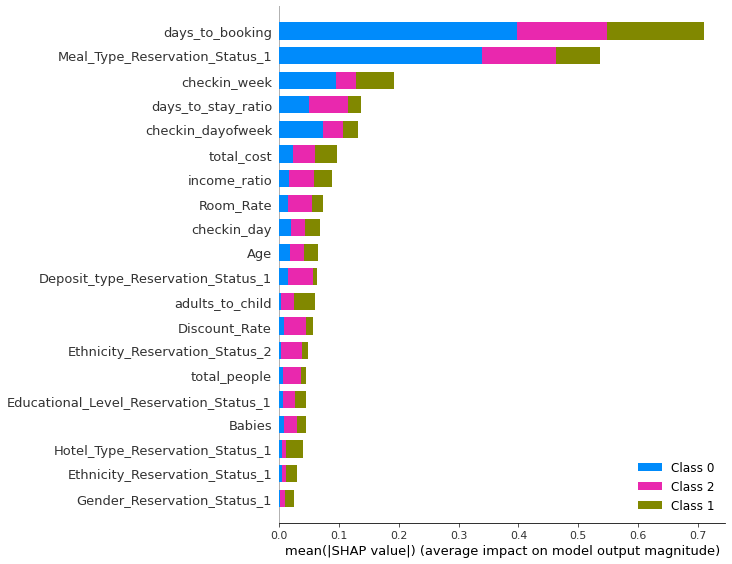

In [81]:
shap_values = shap.TreeExplainer(model).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

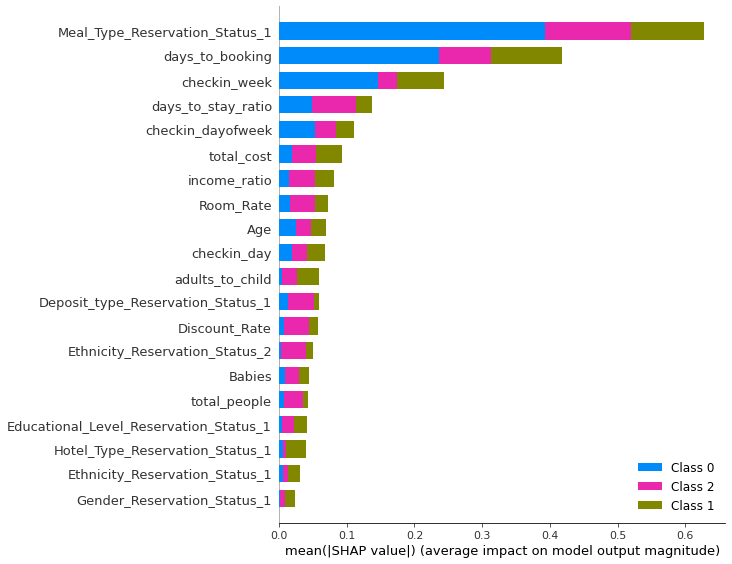

In [84]:
shap.summary_plot(shap_values, val_X)

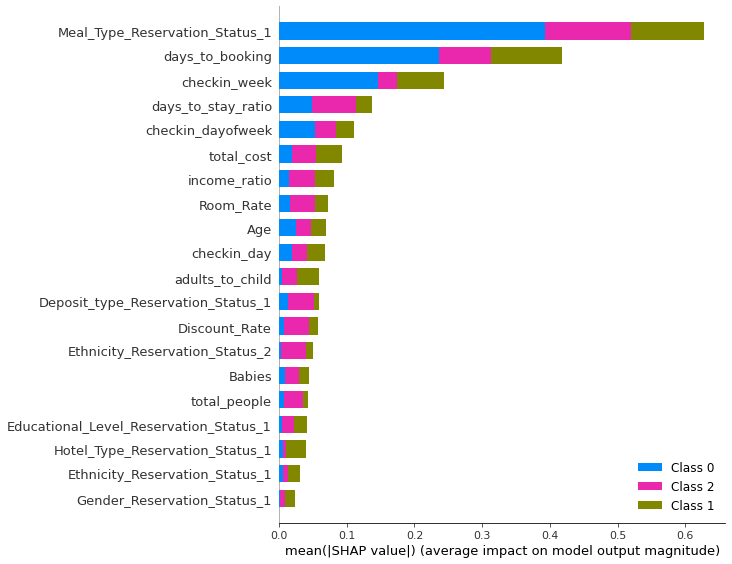

In [82]:
shap_values = shap.TreeExplainer(model).shap_values(val_X)
shap.summary_plot(shap_values, val_X, plot_type="bar")

In [46]:
feat_i = pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

In [47]:
print(feat_i)

Room_Rate                                      5158
total_cost                                     5129
Age                                            4632
income_ratio                                   4375
Discount_Rate                                  2534
Meal_Type_Reservation_Status_1                 1738
Educational_Level_Reservation_Status_1         1369
Adults                                         1097
Ethnicity_Reservation_Status_1                  946
Children                                        921
Hotel_Type_Reservation_Status_1                 895
Income_Reservation_Status_1                     774
Ethnicity_Reservation_Status_2                  762
Country_region_Reservation_Status_1             707
Deposit_type_Reservation_Status_1               706
Booking_channel_Reservation_Status_1            680
Babies                                          670
stay_length                                     603
Country_region_Reservation_Status_2             409
Gender_Reser

In [841]:
feat_i[feat_i < 5].index

Index(['Deposit_type_Reservation_Status_3', 'Gender_Reservation_Status_3',
       'Educational_Level_Reservation_Status_3',
       'Booking_channel_Reservation_Status_3',
       'Visted_Previously_Reservation_Status_3', 'Income_Reservation_Status_3',
       'adults_to_babies', 'Ethnicity_Reservation_Status_3',
       'Previous_Cancellations_Reservation_Status_2',
       'Required_Car_Parking_Reservation_Status_2',
       'Income_Reservation_Status_2', 'Gender_Reservation_Status_2',
       'Visted_Previously_Reservation_Status_2',
       'Booking_channel_Reservation_Status_2',
       'Hotel_Type_Reservation_Status_2', 'Meal_Type_Reservation_Status_2',
       'Previous_Cancellations_Reservation_Status_3',
       'Required_Car_Parking_Reservation_Status_3',
       'Meal_Type_Reservation_Status_3'],
      dtype='object')

In [80]:
sub_y = model.predict(sub_X)

df_test['pred_y'] = sub_y
sub_s = df_test.pred_y
sub_s.name = 'Reservation_status'
sub_s.to_frame().to_csv('../output/submission_file_13Mar_02_00_am.csv', header=True)